In [17]:
from BGN_MC import *

# set up a BGN simulation that will run for 1100ms. pd=True
# signifies that the brain will be simulated in the Parkinsonian
# state. 
bgn = BGN_MC(tmax=1100, pd=True)

# this .reset() function will initialize all neuron readings, 
# and is set to run for 100ms. During this time, no DBS actions
# will be applied to the simulated brain. 
bgn.reset()[0]

# run .step() in a while loop until our simulation is complete.
# .step() is set to run for 100ms, and reports back the 
# observation vector, the reward incurred by the agent if it 
# decided to take an action, a truncated variable which is
# functionally meaningless to us, and an info variable, which 
# may be helpful for debugging. Note that no arguments are being
# passed to the .step() function, and so no DBS will be applied. 
terminated = 0
while terminated != 1:
    observation, reward, terminated, truncated, info = bgn.step()

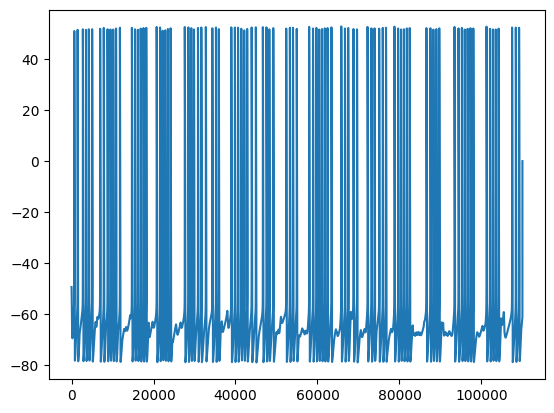

In [18]:
import matplotlib.pyplot as plt
import scipy

# here we can see the results of the above simulations. Using
# scipy, we can load the neuron readings from the bgn_vars.mat
# file and plot them using a simple plotter like matplotlib.
# We simulate the GPi, GPe, thalamus, and sub-thalamic nucleus.
# Each of the variables below is formatted as an array of 10 
# subarries, representing voltage readings from 10 distinct 
# neurons in the respective region. For example, if I want to
# perform some kind of inference on the readings of the first 
# neuron in the GPi, I would refer to these readings as vgi[0].
# You are encouraged to change the pd variable in the bgn 
# definition above and see how the signal shape of the neuron
# voltages changes. 
sgis = scipy.io.loadmat('bgn_vars.mat')['sgis']
vgi = scipy.io.loadmat('bgn_vars.mat')['vgi']
vth = scipy.io.loadmat('bgn_vars.mat')['vth']
vsn = scipy.io.loadmat('bgn_vars.mat')['vsn']
vge = scipy.io.loadmat('bgn_vars.mat')['vge']

plt.plot(vgi[0])

In [19]:
# Now, let's simulate a Parkinsonian brain receiving a constant
# DBS signal. Remeber, a DBS signal (in our research) is made 
# up of both a frequency and amplitude. Additionally, the .step()
# function expects the frequency and amplitude arguments to be
# normalized between [-1, 1], as this is how the RL agent formats
# continuous outputs. So, if we want to send a DBS signal with 
# freq=130 and amp=2500, we normalize these between [-1, 1]. In 
# our experiments, we restrict the frequency the RL agent can 
# choose to be within [0, 185]Hz, and the amplitude to be within
# [0, 5000]mA. With these ranges in mind, we normalize our desired
# values as such:

freq = 130
amp = 2500
norm_freq = (freq/185)*2 - 1
norm_amp = (amp/5000)*2 - 1

# We can then pass these normalized values in a numpy array to the 
# .step() function. 
bgn = BGN_MC(tmax=1100, pd=True)
bgn.reset()[0]
terminated = 0
while terminated != 1:
    observation, reward, terminated, truncated, info = bgn.step(np.array([norm_freq, norm_amp]))

In [20]:
# Here, you are encouraged to plot the resulting neuron readings
# as is explained in the second cell. Notice how the GPi neuron 
# readings are less clumped together and more even, similar to 
# how GPi neurons behave in the healthy brain state. Additionally,
# Note how much smoother the thalamus readings are compared to 
# those from the Parkinsonian state. 

In [ ]:
# Now, let's load in a TD3 model and let it apply DBS.
from stable_baselines3 import TD3 

bgn = BGN_MC(tmax=1100, pd=True)

# Here, we load one of our TD3 models from the td3_agents/ folder and
# tell it to prepare for inference on the BGN model. Our RL agent
# will refer to the BGN model as the environment. Note the naming
# convention of this TD3 model. The TD3 agent utilizes four neural
# networks, each with two hidden layers. The _64_64 part of this
# agent's name indicates it uses 64 nodes in the first and second
# layers. You will be expected to follow these naming conventions
# when creating new models. 
model = TD3.load('models/TD3_64_64/1500.zip', env=bgn)

# We need to pass our agent an initial observation when it begins,
# which is provided by the .reset() function. The observation
# variable is a 6 element vector that includes relevant 
# information about the health and general state of the brain
# model. The .predict() function tells our agent to perform
# inference on a given environment observation. The agent then
# returns the action it thinks is best to carry out for the next
# step length of 100ms. 
observation = bgn.reset()[0]
terminated = 0

# We keep track of the actions the agent takes in an array for 
# demonstration purposes
norm_freqs = []
norm_amps = []

#ignore sgis_sums for now
sgis_sums = []

# start the simulation
while terminated != 1:
    action = model.predict(observation)[0]
    norm_freqs.append(action[0])
    norm_amps.append(action[1])
    observation, reward, terminated, truncated, info = bgn.step(action)

    # ignore this for now
    sgis = scipy.io.loadmat('bgn_vars.mat')['sgis']
    sgis_sums.append(np.sum(np.mean(np.abs(np.fft.fft(sgis)), axis=0)[1:20]))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
# Here, we can print out the some of the actions our agent takes. 
# Remember, these actions are normalized between [-1, 1], so if 
# we want to make sense of them, we should denormalize them.

freqs = [(norm_freqs[i]+1)/2 * 185 for i in range(len(norm_freqs))]
amps = [(norm_amps[i]+1)/2 * 5000 for i in range(len(norm_amps))]
print(f'Some of the frequencies the agent decided upon: {freqs[-5:]}')
print(f'Some of the amplitudes the agent decided upon: {amps[-5:]}')
print(f'The mean of the frequencies: {np.mean(freqs)}')
print(f'The mean of the amplitudes: {np.mean(amps)}')
# Generally, it is a good sign if our average frequency is below 130Hz,
# and our average amplitude is below 2500mA, as these are the parameters
# used by a traditional open loop DBS system. We want an agent that uses
# a low frequency and amplitude, but one that also reduces the SGi and 
# P-beta biomarkers as well. If these conditions are met, it indicates
# that our agent is power-efficient and effective at Parkinson's mitigation.

Some of the frequencies the agent decided upon: [145.69021701812744, 133.9376139640808, 136.7128649353981, 151.49451315402985, 149.30744588375092]
Some of the amplitudes the agent decided upon: [3141.3671374320984, 3101.0308861732483, 3017.423152923584, 3212.047219276428, 3251.180052757263]
The mean of the frequencies: 141.44000121951103
The mean of the amplitudes: 3012.751892209053


In [23]:
# To measure the SGi and P-beta biomarkers, we take the sum of values
# in a specific range given to us by an fft on the SGi readings and 
# the GPi neuron readings. The specifics are shown below. We calculate
# the SGi and P-beta intensity as follows:
sgi_intensity = np.mean(sgis_sums)

vgi = scipy.io.loadmat('bgn_vars.mat')['vgi']
Pb = np.sum(np.average(np.abs(np.fft.fft(vgi)) / 0.1, axis=0)[12:31])
print(sgi_intensity, Pb)
# refer to the table in the BSN paper to compare P-beta and SGi values

1329.5938459816994 2594915.60842963


In [25]:
# Now that we know how to load and use models, let's discuss how to 
# actually train them. First, we need to import the usual, along with
# the Stable Baselines 3 library. This contains a number of pre-built
# RL algorithms that are compatible with OpenAI's Gymnasium styled
# environments, of which our BGN happens to be. We also import the 
# torch module, which lets us define some agent-specific parameters
from stable_baselines3 import TD3
import os
import torch


# Here we define the sizes of our first and second hidden layers. 
# You will experiment with different sized layers, and should change
# such parameters with these two variables. 
h1 = 32
h2 = 32

# We define where to store our models, as well as where to log any metadata
# while training. 
models_dir = f'models/TD3_{h1}_{h2}'
logdir = 'logs'

# Make these directories if they do not already exist. 
if not os.path.exists(models_dir): os.makedirs(models_dir)
if not os.path.exists(logdir): os.makedirs(logdir)

# This line defines the parameters of the TD3 agent. We define the activation
# function to be used by the agent's neural networks, as well as their hidden
# layer sizes. 
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[h1, h2], qf=[h1, h2]))

# We define the model with a standard Multi-layer perceptron style learning 
# model, specify it will act upon the BGN environment, tell it to be verbose
# about any training data, define the architecture parameters specificied above, 
# specify we will use tensorboard to log training data to (more on that in a bit),
# and set the learning rate. 
env = BGN_MC(tmax=1100)
model = TD3('MlpPolicy', env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log=logdir, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Now that we have a defined model, we can train it on the BGN environment. 
# The code below trains the TD3 agent for a set number of timesteps. We do
# not employ any techniques such as reward-based early stopping. Below, every
# 500 timesteps the RL agent will save an intermediate version of itself to 
# its directory in the models/ folder. It will run for 5 iterations of 500
# timesteps, or for a total of 2500 timesteps. You might want to change the 
# num_iters variable if you believe a longer training session is required. 
# You may also change the TIMESTEPS variable if you wish to change the 
# frequency at which models are stored. Note this also changes the total
# number of timesteps you are training for. 
TIMESTEPS = 500
num_iters = 5
for i in range(num_iters):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f'TD3_{h1}_{h2}')
    model.save(f'{models_dir}/{TIMESTEPS*(i+1)}')

# Once you run this, you can see training metrics using tensorboard.
# Run the command: tensorboard --logdir=logs/{agent_name}_0 --reload_multifile=True
# in a separate shell and click the localhost link the command generates.
# agent_name refers to the name given to the agent by our naming scheme in the cell 
# above. For example, training a TD3 agent with both hidden layer sizes set to 32 
# should have and agent_name of TD3_32_32. You can also see this in models/. 
# Navigate to the scalars tab at the top left to see the average episodic reward
# The agent is receiving. We generally want to finish training when the agent receives
# an average reward > -3. Once (or if) this happens, you want to pick the first
# save of the model that achieved this reward. This will be the version of the model
# used in the following steps. 

In [ ]:
# Now that we have a trained agent, we need to apply a second layer of optimization.
# We will quantize our trained model, specifically with post training quantization. 
# Quantization converts the weights in our trained agent from float32 to int8. This
# nearly halves the storage required for our model while also allowing for faster
# computation. However, we will lose some prediction accuracy. Nevertheless, it is
# still an invaluable tool for our purposes. 

# We will use the quantize_dynamic function from pytorch. 
import torch
from torch.ao.quantization import quantize_dynamic

# Define the hidden layer sizes of the already-trained model you want to quantize,
# then load the model
h1 = 32
h2 = 32
model = TD3.load(f'models/TD3_{h1}_{h2}/2500.zip')

# The model's policy is where the actual neural networks are, and is really all
# we need to make predictions. So, extract it from the trained model.
policy = model.policy.to(torch.device('cpu'))

# Set the policy to evaluation mode, since we are not doing any more training.
policy.eval()

# Perform dynamic quantization, and save both the policy and quantized policy.
qpolicy = quantize_dynamic(policy, dtype=torch.qint8)
torch.save(qpolicy.state_dict(), f'models/policies/qpolicy_{h1}_{h2}.pth')
torch.save(policy.state_dict(), f'models/policies/policy_{h1}_{h2}.pth')

In [31]:
# We can now perform inference on the quantized model.
bgn = BGN_MC(tmax=1100, pd=True)

h1 = 32
h2 = 32

# We need to tell SB3's TD3 constructer the general shape and architecture
# of the model we are trying to load. I know there is an easier way to do 
# this, I admittedly just got lazy and went with this route. Sorry :/
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[h1, h2], qf=[h1, h2]))
model = TD3('MlpPolicy', bgn, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.0001)
qmodel = quantize_dynamic(model.policy.to(torch.device('cpu')), dtype=torch.qint8)
qmodel.load_state_dict(torch.load(f'models/policies/qpolicy_{h1}_{h2}.pth'))
qmodel.eval()

sgis_sums = []
Pbs = []
freqs = []
amps = []

# The for loop just runs the quantized model on 5 different instances 
# of the brain model sequentially. To get a good idea of model performance,
# I would loop a MINIMUM of 5 times. More is typically better. 
for i in range(5):
    observation = bgn.reset()[0]
    terminated = 0
    while terminated != 1:
        # Because of the differences between how SB3 and a normal pytorch
        # model handle input, we need to pass our observation as a torch
        # tensor. After doing so, observation is now a 6 element tensor with
        # a shape of (1, 6) (I think). Our model also expects the tensor to 
        # contain information on the 'batch size', or number of observations
        # we are passing, as it can perform inference on multiple observations
        # at once. So, we use the .unsqueeze() function to add an extra 
        # dimension to our observation tensor, which now has shape (1, 1, 6).
        # The first 1 indicates a batch size of just 1 (since we are only passing
        # one observation at a time), and the following 1 and 6 just indicate
        # the height and width of the observation vector. We then place this 
        # tensor on the cpu instead of the gpu. I really hope you have an nvidia
        # gpu, or else getting to this step might have taken forever. 
        observation = torch.from_numpy(observation).unsqueeze(0).to(torch.device('cpu'))
        action = qmodel(observation).numpy()[0]
        observation, reward, terminated, truncated, info = bgn.step(action)
        sgis = scipy.io.loadmat('bgn_vars.mat')['sgis']
        sgis_sums.append(np.sum(np.mean(np.abs(np.fft.fft(sgis)), axis=0)[1:20]))
        freqs.append(action[0])
        amps.append(action[1])
    vgi = scipy.io.loadmat('bgn_vars.mat')['vgi']
    Pb = np.sum(np.average(np.abs(np.fft.fft(vgi)) / 0.1, axis=0)[12:31])
    Pbs.append(Pb)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\ncart\AppData\Local\Temp\ipykernel_14840\1903138884.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load(f'models/policies/qpolicy

In [32]:
# And lastly, check to see how well the quantized model did at supressing
# the SGi intensity and Pb
sgi_intensity = np.mean(sgis_sums)
print(sgi_intensity, Pb)

1213.580144690668 3166630.983185982
